# Error of the estimated mean for time-series data


A common analysis task is determining the mean	value of a metric in a population - here we consider the metric to be the arithmetic mean. Because we don't have access to the entire population, this is almost always done by taking some sample data from the broader population, measuring the mean in the sample, then taking that measurement as an estimation of the true value (hence 'estimator'). Because the estimator doesn't return the exact true value, it should be accompanied by error bars. For sample data that is independent, calculating the standard error of the estimated mean is trivial using a formula. Some other data, for example time series, are highly correlated and thus need some adjustments to determine the error. 

Despite the broad range of fields that measure time series data - ecology, econometrics, physical simulations, astronomy, etc... - there's no single, accepted approach to calculating the standard error of the mean, motiviating this article.  


This article demonstrates four different techniques for determing the standard error of the estimated mean:
- Block averaging
- Using a correction factor
- Autoregressive (AR(1)) maximum likelihood fit
- Autoregressive (AR(1)) bayesian fit


------------

First, to demonstrate the problem, below shows examples of independent data (top panel) and highly correlated data time series data (bottom panel):


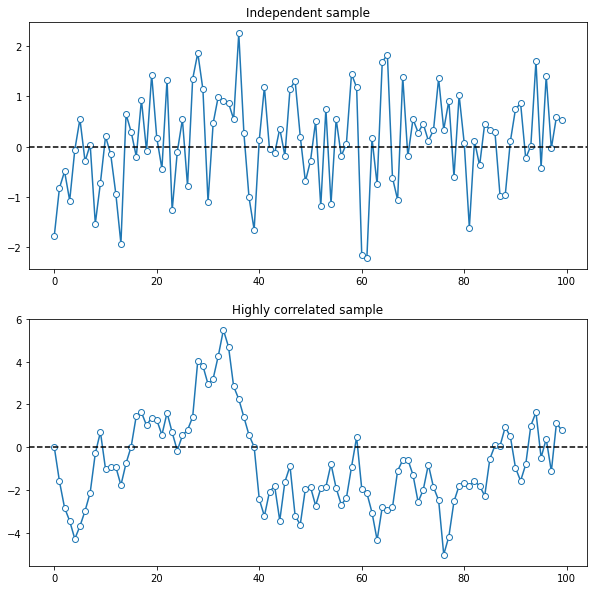

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(2572367)


def gen_correlated_curve(ac, num=100, innovation=1):
    y = np.zeros((num,))
    for i in range(1,num):
        y[i] = ac * y[i-1] + np.random.normal()*innovation
    return y

uncorrelated = np.random.randn(100)
correlated = gen_correlated_curve(0.90)

fig, ax = plt.subplots(ncols=1, nrows=2); fig.set_figheight(10); fig.set_figwidth(10)
ax[0].plot(uncorrelated, '-o', mfc='white'); ax[0].set_title('Independent sample'); ax[0].axhline(0, c='k', linestyle='--')
ax[1].plot(correlated, '-o', mfc='white'); ax[1].set_title('Highly correlated sample'); ax[1].axhline(0, c='k', linestyle='--')


The key difference is that in the case of highly correlated data, each new point is very similar to the previous one. This is known as autocorrelation. For independent data this is not the case - each new point has no memory of the previous points even though all points are still centred on a common mean value. 

This causes difficulty when calculating error bars. Normally, for independent data, when estimating the mean value you would calculate the standard error of that estimate using:

\begin{align}
SEM = \frac{s}{\sqrt{n}}
\end{align}

which in english says "the standard error of the (estimated) mean, called $SEM$, is equal to the standard deviation ($s$) of the sample divided by the square root of the number of samples". The formula isn't so special, it can be found on the wikipedia entry for [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error). 

The problem with using this formula for highly correlated data is the $\sqrt{n}$ in the denominator - it can become very large for time series data, especially if you take samples at high frequency. Consider an example: measure your body temperature every hour for four weeks. It fluctuates over the day/night cycle, but doesn't change too much hour by hour. In that case, $n=672$. Now imagine measuring it every minute for a month, so $n=40320$. The $n$ has multiplied by $60$, meaning the $SEM$ becomes smaller by $\sqrt{60}$. Yet in both cases you sampled for the same total time. Your actual body temperature would have varied by about the same amount, meaning you would expect the error bars to be about the same.


Put another way, high frequency sampling of a time-varying process gives you lots of unnecessary data points because each point is similar to its neighbours, and this makes the sample look very precise when it isn't. 



# Autocorrelation

This correlation between adjacent points can be visualized using an `autocorrelation plot`. Autocorrelation plots range from `-1 to 1` and measure how correlated adjacent points are, with `1` being total positive correlation, `0` being no correlation at all, and `-1` being total negative correlation. Autocorrelation plots measure how correlated a sample is to another point at some time lag. When the time lag is zero, autocorrelation must be `1` because each point must be completely positively correlated with itself! 

The below shows an example of three time series with different levels of positive correlation. When the autocorrelation plot reaches zero, it's safe to assume that the time lag is big enough that any data point has no memory of another data point separated by that lag. This value of the time lag is characteristic to an autocorrelated process, and is called the 'autocorrelation time' ($\tau$, tau). In practice, there's a lot of noise around the autocorrelation of zero which appears even using independent data. 

`??? See Detecting Signals from Data with Noise: Theory and Applications` for significance testing of autocorrelation vs. white noise 


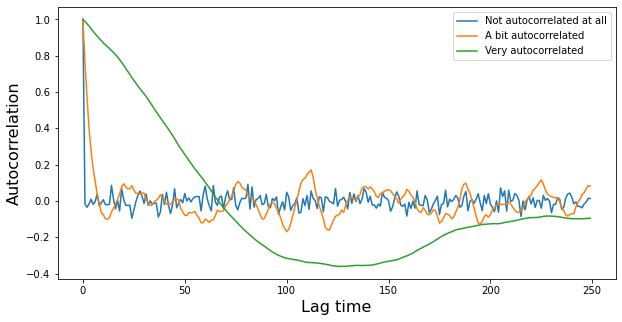

In [2]:
plt.figure(figsize=(10, 5))
for ac, label in zip([0, 0.8, 0.99], ['Not autocorrelated at all', 'A bit autocorrelated', 'Very autocorrelated']):
    curve = gen_correlated_curve(ac, num=500)
    #calculate autocorrelation:
    co = np.correlate(curve-curve.mean(),curve-curve.mean(), mode='same')
    co = co/co.max()
    co = co[int(co.shape[0]/2):]
    
    plt.plot(co,label=label)

plt.legend()
plt.xlabel('Lag time', fontsize=16)
_=plt.ylabel('Autocorrelation', fontsize=16)

# Approach 1: Block averaging
'Undoing' the autocorrelation allows us to calculate $SEM$ as if the sample was independent. One way to do this is block averaging. First, a baseline value for the $SEM$ is calculated using all points. To do one round of block averaging, every second point and it's adjacent point forward in time are averaged, creating 'blocks' of size 2 and resulting in a dataset with $ \frac{n}{2} $ points. 

Here's an example:

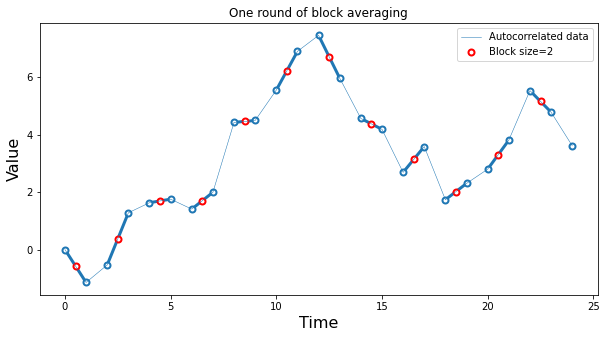

In [3]:

correlated = gen_correlated_curve(0.99, num=25)
x = np.arange(len(correlated))

plt.figure(figsize=(10,5))
plt.title('One round of block averaging')
plt.plot(x,correlated,mew=1, linewidth=0.5, label='Autocorrelated data')

#plot pairs:
for i in range(0,13):
    plt.plot(x[i*2:i*2+2],correlated[i*2:i*2+2],'-o', c='C0', mfc='white', mew=2, linewidth=3, zorder=0)

#do one round of block averaging, blocksize of 2
x_ = x[:len(x)-(len(x)%2)].reshape(-1,2).mean(1)
y_ = correlated[:len(x)-(len(x)%2)].reshape(-1,2).mean(1)

plt.scatter(x_, y_, facecolor='white', edgecolor='red', linewidth=2,zorder=2, label='Block size=2')
plt.xlabel('Time',fontsize=16)
plt.ylabel('Value',fontsize=16)
_=plt.legend()

By increasing the size of the blocks from 2,3,4..., the hope is that eventually adjacent blocks are far enough apart in time that they are totally uncorrelated and the data resemble an independent sample. This occurs when the blocks are bigger than the autocorrelation time $\tau$. It appears as an asymptote in the $SEM$, and would also correspond to reaching zero in the autocorrelation plot. 

To demonstrate, the below shows blocks up to `size=200` using 5000 points from an autocorrelated time series: 

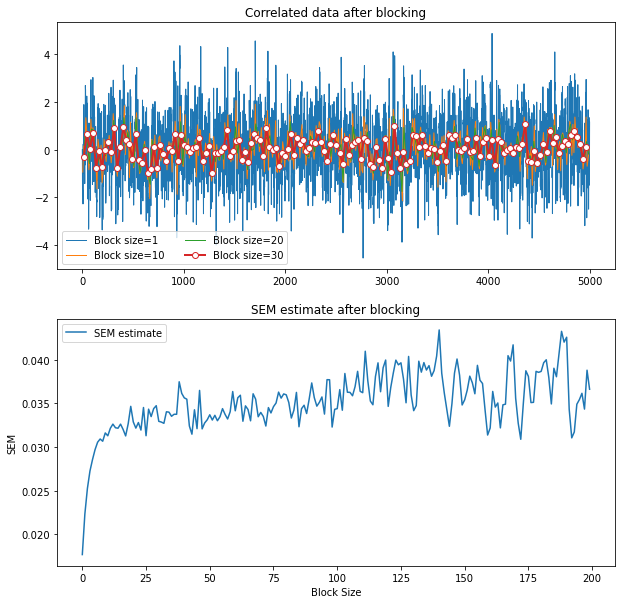

In [634]:
from scipy.stats import sem

correlated = gen_correlated_curve(0.6, num=5000)
x = np.arange(correlated.shape[0])

def do_block_averaging(corr, n=200):
    sems = list()
    for blocksize in range(1, n+1):
        #this is the blocking bit:
        x_ = x[:len(x)-(len(x)%blocksize)].reshape(-1,blocksize).mean(1)
        y_ = correlated[:len(x)-(len(x)%blocksize)].reshape(-1,blocksize).mean(1)
        sems.append(sem(y_))

fig, ax = plt.subplots(ncols=1, nrows=2)
fig.set_figwidth(10)
fig.set_figheight(10)


    
    #plotting
    if blocksize in [1, 10, 20]:
        ax[0].plot(x_,y_, label='Block size='+str(blocksize), linewidth=1)
    if blocksize==30:
        ax[0].plot(x_,y_, '-o', mfc='white', label='Block size='+str(blocksize), linewidth=2)
#     if blocksize==20:
#         ax[1].axhline(sem(y_), c='k', linestyle='--', label='Reasonable choice for asymptote')

ax[1].plot(sems, label='SEM estimate')
ax[0].legend(ncol=2)
ax[0].set_title('Correlated data after blocking')
ax[1].set_xlabel('Block Size')
ax[1].set_ylabel('SEM')
ax[1].set_title('SEM estimate after blocking')
_=ax[1].legend()

There are a few problems with this approach:

- **Wasting data**. In order to maintain identically distributed blocks, each block should be exactly the same size. So, what if the block size doesn't evenly divide the total number of measurements? The overhanging data has to be discarded, which is a waste of perfectly good measurements
- **Noise** - as seen above, the $SEM$ values become noisy after the asymptote is reached, rather than converging towards the true value. This is a consequence of cutting data - as the block size grows, larger and larger overhanging chunks get removed until the blocksize is an even divisor of the number of samples. The changes in the amount of data being used leads to jumps in the calculated $SEM$.
- **Arbitrary choice of asymptote**. By eye it seems pretty obvious what region the $SEM$ lies in, but how do you choose a consensus value? One way to remedy this is to automate the choice by fitting some curve that also grows to an asymptote like the $SEM$. There doesn't appear to be a known curve to use for the fit, but curves based on `y=arctan(x)` work. However, on the edge cases where the optimum block size is only 2 or 3, or it's nearly as many samples as you have, the fit can be (wildly) inaccurate.


Because we have a good smooth curve above, the below demonstrates fitting the curve `y= a*arctan(b*(x-c))` to find the asymptote of the $SEM$.


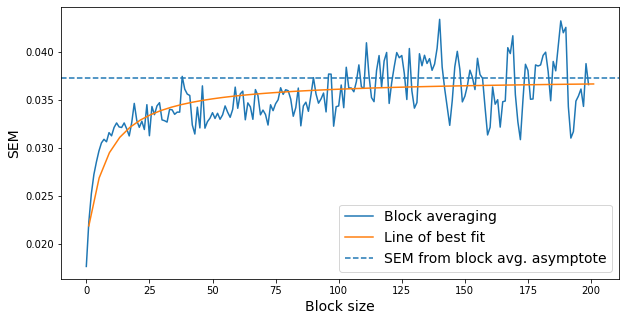

In [635]:
# fitting to arctan
from scipy import optimize

def block_avg_fit(x, a, b, c):
    return a * np.arctan(b*(x-c))

popt, pcov = optimize.curve_fit(block_avg_fit, np.arange(1, 201), np.array(sems))

plt.figure(figsize=(10,5))
plt.plot(sems, label='Block averaging')
plt.ylabel('SEM', fontsize=14)
plt.xlabel('Block size', fontsize=14)

x = np.linspace(1,201)
plt.plot(x, block_avg_fit(x, popt[0], popt[1],popt[2]), label='Line of best fit')
plt.axhline(popt[0] *np.pi/2, label='SEM from block avg. asymptote', linestyle='--')

plt.legend(fontsize=14)

So block bootstrapping works well if you have lots of data and a smooth curve. But what to do in other cases? Below demonstrates some alternatives that use all the available data and give definite answers without requiring a good block averaging plot.

# Approach 2: Estimating $n_{eff}$ from the autocorrelation function

Block averaging works by reducing $n$ until the $SEM$ converges. At this point, we expect adjacent points to look independent. The value of $n$ that achieves this is known as the 'effective $n$', or $n_{eff}$, and it reflects how many independently sampled data points you actually have in the sample. There are other ways to calculate $n_{eff}$ that are more direct than block averaging, and interestingly they can result in fractional values.  

Remembering the wikipedia equation for $SEM$, we now have:

\begin{align}
SEM = \frac{s}{\sqrt{n_{eff}}}
\end{align}

Calculating $n_{eff}$ normally happens by first calculating the autocorrelation time $\tau$. The autocorrelation time is the time it takes for the process to forget a past value - meaning  the autocorrelation plot should be close to zero. This time, of course, doesn't need to be an integer value, which is how $n_{eff}$ can be fractional. 

\begin{align}
n_{eff} = \frac{n}{\tau}
\end{align}

So how to find $\tau$? The two techniques given below, called here Sokal and Chodera, estimate $\tau$ from the autocorrelation function and have reasonable agreement with block averaging.



>Chodera: see https://github.com/choderalab/pymbar for code, and `Use of the Weighted Histogram Analysis Method for the Analysis of Simulated and Parallel TemperingSimulations`
>
>Sokal: see https://dfm.io/posts/autocorr/ for code, [here](https://pdfs.semanticscholar.org/0bfe/9e3db30605fe2d4d26e1a288a5e2997e7225.pdf) for Sokal notes


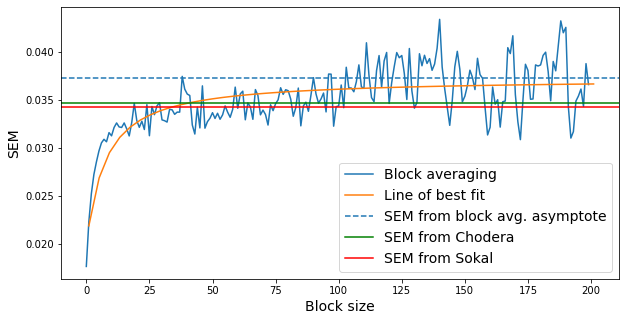

In [636]:
import statsmodels.api as sm
def next_pow_two(n):
    #lew: complicated one-liner: int(2**(np.ceil(np.log2(number))))
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x):
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n 
    acf /= acf[0]
    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def sokal_autocorr_time(corr):
    f = autocorr_func_1d(corr)
    taus = 2.0*np.cumsum(f)-1.0
    c=5
    window = auto_window(taus, c)
    return taus[window]

def statineff(corr,mintime=3):
    N = corr.size
    C_t = sm.tsa.stattools.acf(correlated, fft=True, unbiased=True, nlags=N)
    t_grid = np.arange(N).astype('float')
    g_t = 2.0 * C_t * (1.0 - t_grid / float(N))
    ind = np.where((C_t <= 0) & (t_grid > mintime))[0][0]
    g = 1.0 + g_t[1:ind].sum()
    return max(1.0, g)


#chodera:
chodera_autoc_time = statineff(correlated)

#sokal:
sokal_autoc_time = sokal_autocorr_time(correlated)

n=len(correlated)
chodera_sem = np.std(correlated) / np.sqrt(n/chodera_autoc_time)
sokal_sem = np.std(correlated) / np.sqrt(n/sokal_autoc_time)

plt.figure(figsize=(10,5))
plt.plot(sems, label='Block averaging')
plt.ylabel('SEM', fontsize=14)
plt.xlabel('Block size', fontsize=14)
plt.plot(x, block_avg_fit(x, popt[0], popt[1],popt[2]), label='Line of best fit')
plt.axhline(popt[0] *np.pi/2, label='SEM from block avg. asymptote', linestyle='--')
plt.axhline(chodera_sem, label='SEM from Chodera', c='green')
plt.axhline(sokal_sem, label='SEM from Sokal', c='red')
plt.legend(fontsize=14)


# Approach 3: Autoregressive processes
A third way to estimate the $SEM$ is by treating it as an autoregressive process. Here, it helps to understand what it is that makes time series correlated with themselves. The simplest model of autocorrelation is called an `autoregressive model` where we only consider the time lag at lag=1, commonly just called `AR(1)`. [Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_model) has some more details on these, but here's the short version. In an AR(1) process, each new point is equal to the previous point multiplied by a number $\rho$ (rho), plus or minus some white noise (i.e. random noise).

In maths, using $X_t$ to mean 'point $X$ at time $t$' and $\epsilon$ to mean 'random noise':

\begin{align}
X_t = \rho X_{t-1} + \epsilon
\end{align}

When $\rho$ is less than 1, each step pulls the point back towards zero (hence auto*regressive*), meaning the time series will maintain a mean of zero. Moving average models are also commonly used, but a stationary mean makes things a bit easier. If your time series is not centred on zero, the AR(1) model can just add a constant that shifts the whole sample back to zero, and then still use the model above. 

First, let's estimate the $\rho$ parameter. This can be done using linear regression, where you calculate the line of best fit between all the points and their adjacent neighbours. The true $\rho$ in this case was 0.6.


In [637]:
from statsmodels.tsa.ar_model import AutoReg

#find estimated rho using Ordinary least squares
result = AutoReg(correlated-correlated.mean(), lags = [1]).fit()
estimated_rho = result.params[1]
print(f'Estimated rho is {estimated_rho}, with 95% CI of {result.conf_int()[1]}')

Estimated rho is 0.5884316477096136, with 95% CI of [0.56601538 0.61084792]


Not a bad estimate for $\rho$. Next, we can use a handy consequence of autoregressive processes to get an estimate for the $SEM$. The $SEM$ gets calculated naively, giving the wrong answer. Then it's multiplied by a correction factor $k$, which is:

\begin{align}
k = \sqrt{\frac{1+\rho}{1-\rho}}
\end{align}

So now:

\begin{align}
SEM = \frac{ks}{\sqrt{n}}
\end{align}

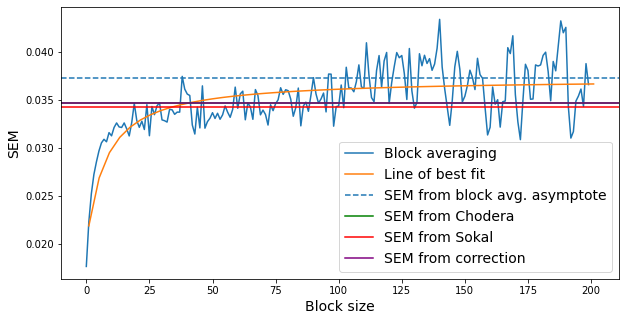

In [638]:
correction = np.sqrt((1+estimated_rho)/(1-estimated_rho))

plt.figure(figsize=(10,5))
plt.plot(sems, label='Block averaging')
plt.ylabel('SEM', fontsize=14)
plt.xlabel('Block size', fontsize=14)
plt.plot(x, block_avg_fit(x, popt[0], popt[1],popt[2]), label='Line of best fit')
plt.axhline(popt[0] *np.pi/2, label='SEM from block avg. asymptote', linestyle='--')
plt.axhline(chodera_sem, label='SEM from Chodera', c='green')
plt.axhline(sokal_sem, label='SEM from Sokal', c='red')
plt.axhline(sem(correlated)*correction, label='SEM from correction', c='purple')
plt.legend(fontsize=14)

Before moving on, it's also neat to see how big this correction factor can get. At $\rho$ close to 0, i.e. less than about 0.2, $k$ is barely greater than 1. But as $\rho$ approaches 1, the $k$ grows very, very large. Because the numbers get so big here, you would probably need very large sample sizes to get precise estimates if the process is highly autocorrelated.  

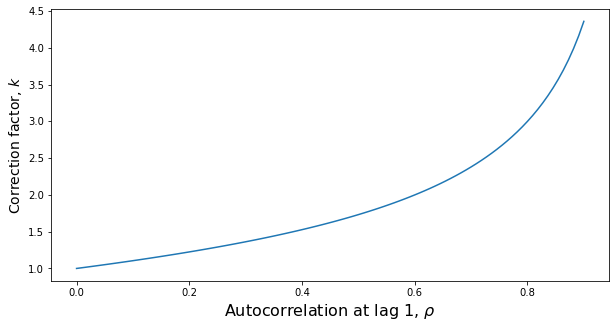

In [639]:
def correction_factor(rho, n):
    d = ((n-1)*rho - n*rho**2 + rho**(n+1)) / (1-rho)**2
    k = np.sqrt( (1 + (2*d)/n) / ( 1 - (2*d)/(n*(n-1))  ) )
    return k

x = np.linspace(0,0.9,100)
plt.figure(figsize=(10,5))
plt.ylabel('Correction factor, $k$',fontsize=14); plt.xlabel('Autocorrelation at lag 1, $\\rho$',fontsize=16)
_ = plt.plot(x, correction_factor(x, 10000))


# Approach 4: AR(1) via Bayesian estimation
The above approaches report what is known as the `maximum likelihood` estimate of the $SEM$. It's called maximum likelihood simply because it's the single most likely value after you factor in any model assumptions you might have made (like the AR(1) assumption, or normally-distributed noise). 

An alternative is Bayesian estimation. There are, of course, still model assumptions - this still uses an AR(1) model. The trick here is that we try and find the $\rho$ parameter by also estimating where the mean value is. Afterwards, we can throw away the $\rho$ estimate and just look at the most probable values for the mean. These most probable values are encompassed in a 'highest posterior density' which can be directly interpreted as a probability (unlike confidence intervals). 

The below demonstrates a Bayesian fit of an AR(1) model, using the `PyMC3` library, which jointly estimates the value of the mean and the $\rho$, and can then report a full spectrum of likely values for the mean (or for $\rho$ if you want). The 95% highest posterior density is used instead of the $SEM$.

In [9]:
import pymc3 as pm
with pm.Model() as ar1:
    k_ = pm.Uniform('k',-1,1) #we assume process is stationary, so -1<k_<1 
    tau_ = pm.Gamma('tau',mu=1,sd=1)
    center = pm.Normal('center', mu=correlated.mean(), sigma=5) #set the prior for the mean to be centred onthe population mean
    likelihood = pm.AR1('likelihood', k=k_, tau_e=tau_, observed=correlated-center)
    trace = pm.sample(2000)
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [center, tau, k]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:03<00:00, 1490.77draws/s]


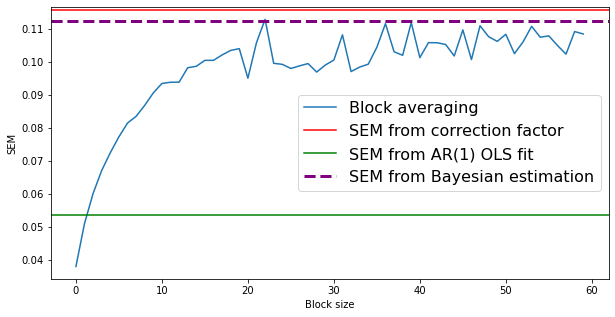

In [11]:
plt.figure(figsize=(10,5))
plt.plot(sems, label='Block averaging')
plt.axhline(sem(correlated)*correction, c='red', label='SEM from correction factor')
plt.axhline(population_sem, c='green', label='SEM from AR(1) OLS fit')

plt.axhline(np.abs(pm.stats.hpd(trace['center'])/1.96).sum()/2, c='purple', linestyle='--', linewidth=3,
            label='SEM from Bayesian estimation')
plt.ylabel('SEM')
plt.xlabel('Block size')
plt.legend(fontsize=16)



There's a lot more analysis one might do with the results here. As a taste, you can plot the posterior density of the mean value, along with the 95% probability bounds (equivalent to the $SEM$). In lay terms, this means it can tell you what the 95% limits are, as well as how probable all the intermediate values are for the mean, which arguably is much more useful than just the error bounds. 

For example:


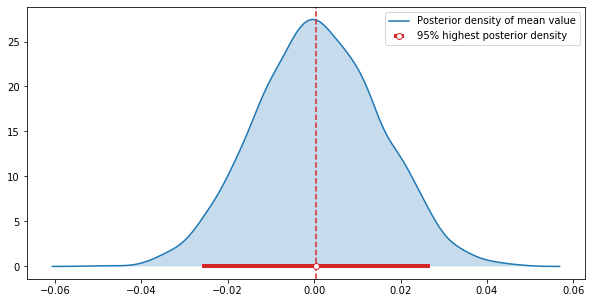

In [9]:
from seaborn import kdeplot
plt.figure(figsize=(10,5))
kdeplot(trace['center'], shade=True, label='Posterior density of mean value')

hpd = pm.stats.hpd(trace['center'])
plt.errorbar([hpd.mean()], [0], xerr = np.abs(hpd.mean()-hpd[:,None]),c='C3',
             linewidth=4,fmt='o', mfc='white', label='95% highest posterior density')
plt.axvline(hpd.mean(), c='C3', linestyle='--')
plt.legend()

See: 
*Confidence intervals in stationary autocorrelated time series*. Halkos, George and Kevork, Ilias,
at: https://mpra.ub.uni-muenchen.de/31840/1/MPRA_paper_31840.pdf , who reference:
`Fishman, G., 1978. Principles of Discrete Event Simulation. Wiley, New York.`

In [ ]:
from scipy.signal import periodogram
#out = periodogram(correlated)
#out= welch(correlated)
peri=np.abs(np.fft.fft(correlated)**2)/len(correlated)
out = peri[:peri.shape[0]//2]
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import OLS
x_ = np.arange(len(out[1:200]))
y_ = np.log(out[1:200])

res = OLS(y_, add_constant(x_)).fit()

I = np.e**res.params[0]
print(I, I/np.var(correlated))

In [ ]:
When you don't have enough data, the above can be a bad approximation. The full version is a bit messier:

\begin{align}
k = \sqrt{\frac{1+2\delta / n}{1 - 2\delta/(n(n-1))}}
\end{align}

where

\begin{align}
\delta = \frac{(n-1)\rho - n\rho^2 + \rho^{n+1}}{(1-\rho)^2}
\end{align}